In [65]:
from langchain.chat_models import ChatOpenAI
from langchain.prompts import ChatPromptTemplate, SystemMessagePromptTemplate, HumanMessagePromptTemplate
from langchain.schema import AIMessage, HumanMessage, SystemMessage
from langgraph.graph import MessagesState
from langgraph.graph import START,StateGraph,END



from langchain_groq import ChatGroq

import re
import httpx
from typing import Literal

from IPython.display import Image, display


In [66]:
import os, getpass

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

# _set_env("OPENAI_API_KEY")
_set_env("GROQ_API_KEY")

In [67]:
### tools

def calculate(what):
    return eval(what)

def wikipedia(q):
    return httpx.get("https://en.wikipedia.org/w/api.php", params={
        "action": "query",
        "list": "search",
        "srsearch": q,
        "format": "json"
    }).json()["query"]["search"][0]["snippet"]

known_actions = {
    "wikipedia": wikipedia,
    "calculate": calculate,
}

class MessagesState(MessagesState):
    tool_list:dict
    question:str
    last_msg:str
    answer:str
    action:str

In [68]:
system_template = """You run in a loop of Thought, Action, PAUSE, Observation.
At the end of the loop you output an Answer
Use Thought to describe your thoughts about the question you have been asked.
Use Action to run one of the actions available to you - then return PAUSE.
Observation will be the result of running those actions.
Answer: the final answer to the original question

Your available actions are:

calculate:
e.g. calculate: 4 * 7 / 3
Runs a calculation and returns the number - uses Python so be sure to use floating point syntax if necessary

wikipedia:
e.g. wikipedia: Django
Returns a summary from searching Wikipedia

Other:
e.g:Other: prompt for the llm to define next action
Runs a llm reasoning and results the response of the llm

Always look things up on Wikipedia if you have the opportunity to do so.

Example session:
# Example1
Question: What is the capital of France?
Thought: I should look up France on Wikipedia
Action: wikipedia: France
PAUSE

You will be called again with this:

Observation: France is a country. The capital is Paris.

You then output:

Answer: The capital of France is Paris

# Example2
Question: What is 3 * 12 ?
Thought: I should calculate the result of 3 * 12
Action: calculate: 3 * 12
PAUSE


You will be called again with this:

Observation: 36
Answer: 36

Remember:
1. CRITICAL - when your perform multiple task ensure results of all the task is taken in to account
2. Action must be one of the below value ["calculate","wikipedia","Other"]

""".strip()

human_template = """Question: {question}"""

In [69]:
def initNode(state:MessagesState):    
    state["messages"] = [SystemMessage(content=system_template),
                         HumanMessage(content=human_template.format(question=state["question"])) ]
    return state

def invokeLLM(state:MessagesState):
    llm = ChatGroq(model="llama3-8b-8192",temperature=0)
    response = llm.invoke(state["messages"])
    state["messages"] = AIMessage(content=response.content)
    state["last_msg"] = response.content
    return state


def parseOutput(state:MessagesState):
    # print("Entered Parser - "+output)
    output = state["last_msg"]
    action_match = re.search(r'Action: (.*)', output)
    final_answer_match = re.search(r'Answer: (.*)', output)

    action = action_match.group(1).strip() if action_match else None
    final_answer = final_answer_match.group(1).strip() if final_answer_match else None
    state["action"] = action
    state["answer"] = final_answer
    return state

def checkAnswer(state:MessagesState) -> Literal["callAction","formatAnswer"]:
    if state["answer"]:
        return "formatAnswer"
    else:
        return "callAction"   


def callAction(state:MessagesState):
    action = ""
    action_input=""
    try:
        action, action_input = state["action"].split(":")
        print(" -- running {} {}".format(action, action_input))
        if action not in known_actions:
            raise Exception("Unknown action ") 
        observation = state["tool_list"][action](action_input)
        state["messages"]  = HumanMessage(content=f"Observation: {observation}")
    except Exception:
        state["messages"] = HumanMessage(content=f"Observation: {action_input}") 
    return state    


def formatAnswer(state:MessagesState):
    state["answer"] = "Answer {}".format(state["answer"] ) 
    return state




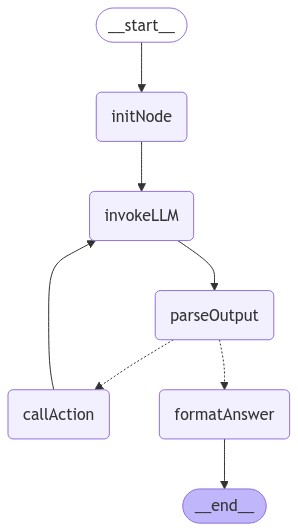

In [70]:
graph_builder = StateGraph(MessagesState)
graph_builder.add_node("initNode",initNode) 
graph_builder.add_node("invokeLLM",invokeLLM)   
graph_builder.add_node("parseOutput",parseOutput)
graph_builder.add_node("callAction",callAction)
graph_builder.add_node("formatAnswer",formatAnswer)


graph_builder.add_edge(START,"initNode")
graph_builder.add_edge("initNode","invokeLLM")
graph_builder.add_edge("invokeLLM","parseOutput")
graph_builder.add_conditional_edges("parseOutput",checkAnswer)

graph_builder.add_edge("callAction","invokeLLM")
graph_builder.add_edge("formatAnswer",END)
graph = graph_builder.compile()

display(Image(graph.get_graph().draw_mermaid_png()))


In [76]:
graph.config_specs

[]

In [71]:
# graph.invoke({"question":"What is 3 * 12?","tool_list":known_actions})

In [72]:
response = graph.invoke({"question":"What is the sum of 3 and 5 and Explain speciality of India ","tool_list":known_actions})

print(response["answer"])
for msg in response["messages"]:
    msg.pretty_print()

 -- running calculate  3 + 5
 -- running wikipedia  India
 -- running Other  What are some specialties of India?
 -- running wikipedia  Indian Space Research Organisation
 -- running wikipedia  Chandrayaan-1
 -- running Other  Summarize the answer
Answer The sum of 3 and 5 is 8, and one of India's specialties is its achievements in space exploration, such as the Chandrayaan-1 mission.
================================ System Message ================================

You run in a loop of Thought, Action, PAUSE, Observation.
At the end of the loop you output an Answer
Use Thought to describe your thoughts about the question you have been asked.
Use Action to run one of the actions available to you - then return PAUSE.
Observation will be the result of running those actions.
Answer: the final answer to the original question

Your available actions are:

calculate:
e.g. calculate: 4 * 7 / 3
Runs a calculation and returns the number - uses Python so be sure to use floating point syntax if ne

In [77]:
response = graph.invoke({"question":"Add 3 and 4, then multiply by 2, and finally divide by 5","tool_list":known_actions})

print(response["answer"])
for msg in response["messages"]:
    msg.pretty_print()

 -- running calculate  (3 + 4) * 2 / 5
Answer The result of the operations is 2.8.
================================ System Message ================================

You run in a loop of Thought, Action, PAUSE, Observation.
At the end of the loop you output an Answer
Use Thought to describe your thoughts about the question you have been asked.
Use Action to run one of the actions available to you - then return PAUSE.
Observation will be the result of running those actions.
Answer: the final answer to the original question

Your available actions are:

calculate:
e.g. calculate: 4 * 7 / 3
Runs a calculation and returns the number - uses Python so be sure to use floating point syntax if necessary

wikipedia:
e.g. wikipedia: Django
Returns a summary from searching Wikipedia

Other:
e.g:Other: prompt for the llm to define next action
Runs a llm reasoning and results the response of the llm

Always look things up on Wikipedia if you have the opportunity to do so.

Example session:
# Example1

In [84]:
response = graph.invoke({"question":" Explain speciality of India and What is the sum of 3 and 5 ","tool_list":known_actions},{"recursion_limit": 50})

print(response["answer"])
for msg in response["messages"]:
    msg.pretty_print()

 -- running wikipedia  India
 -- running wikipedia  India
 -- running calculate  3 + 5
 -- running Other  The specialties of India include its rich cultural heritage, diverse cuisine, and vibrant cities, and the sum of 3 and 5 is 8.
Answer The specialties of India include its rich cultural heritage, diverse cuisine, and vibrant cities, and the sum of 3 and 5 is 8.
================================ System Message ================================

You run in a loop of Thought, Action, PAUSE, Observation.
At the end of the loop you output an Answer
Use Thought to describe your thoughts about the question you have been asked.
Use Action to run one of the actions available to you - then return PAUSE.
Observation will be the result of running those actions.
Answer: the final answer to the original question

Your available actions are:

calculate:
e.g. calculate: 4 * 7 / 3
Runs a calculation and returns the number - uses Python so be sure to use floating point syntax if necessary

wikipedia:
e